<a href="https://colab.research.google.com/github/katyk20/distance-education-highered/blob/main/Notebooks/TimeSeriesForecasting(Univariate)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/katyk20/distance-education-highered

Cloning into 'distance-education-highered'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 122 (delta 60), reused 20 (delta 7), pack-reused 0
Receiving objects: 100% (122/122), 1.90 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [3]:
%cd /content/distance-education-highered
!git pull

/content/distance-education-highered
Already up to date.


In [ ]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [ ]:
! pip install mlflow

In [ ]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret

    what_is_installed()


System:
    python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.58+-x86_64-with-glibc2.35

PyCaret required dependencies:
                 pip: 23.1.2
          setuptools: 67.7.2
             pycaret: 3.3.1
             IPython: 7.34.0
          ipywidgets: 7.7.1
                tqdm: 4.66.2
               numpy: 1.25.2
              pandas: 2.0.3
              jinja2: 3.1.3
               scipy: 1.11.4
              joblib: 1.3.2
             sklearn: 1.4.2
                pyod: 1.1.3
            imblearn: 0.12.2
   category_encoders: 2.6.3
            lightgbm: 4.1.0
               numba: 0.58.1
            requests: 2.31.0
          matplotlib: 3.7.1
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.15.0
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         statsmodels: 0.14.2
              sktime: 0.26.0
               tbats: 1.1.3
            pmdari

In [ ]:
import time
import numpy as np
import pandas as pd

from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment
# import the regression module**
from pycaret.regression import *


import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

Process enrollment data

In [ ]:
#function to process enrollment data

def process_enrollment_data(enrolled):
    # Filter for EFDELEV = 1 (Summary line for each institution)
    enrolled_sum = enrolled[enrolled['EFDELEV'] == 1]

    # Keep columns of interest for time forecasting
    cols_to_keep = ['UNITID', 'INSTNM', 'YEAR', 'EFDETOT', 'EFDEEXC', 'EFDESOM', 'EFDENON']
    enrolled_sum = enrolled_sum[cols_to_keep]

    # Remove rows where EFDEEXC == 0
    enrolled_sum = enrolled_sum[enrolled_sum['EFDEEXC'] != 0]

    # Group the data by 'UNITID' and count the number of unique years for each group
    unitid_year_counts = enrolled_sum.groupby('UNITID')['YEAR'].nunique()

    # Get the total number of unique years in the dataframe
    total_unique_years = enrolled_sum['YEAR'].nunique()

   # Filter 'UNITID's that have data for every year in the dataframe
    filtered_unitids = unitid_year_counts[unitid_year_counts == total_unique_years].index

    # Get institutions corresponding to the filtered 'UNITID's
    filtered_de = enrolled_sum[enrolled_sum['UNITID'].isin(filtered_unitids)]

    return filtered_de, filtered_de['INSTNM'].unique().tolist()




In [ ]:
#distance education enrollment data 2018-2022
enrolled_1822 = pd.read_csv('/content/drive/MyDrive/Capstone_Winter2024/PROJECT DATASETS/dist_enrollment18_22.csv')
filt_enroll_data_1822, institution_names = process_enrollment_data(enrolled_1822)

##Check shape and number of unique institutions:
# filt_enroll_data_1822.shape #(13015, 7)
# #number of unique institutions in dataset
# len(institution_names) #2748

In [ ]:
#Distance education enrollment data 2012-2022
enrolled_1222 = pd.read_csv('/content/drive/MyDrive/Capstone_Winter2024/PROJECT DATASETS/dist_enrollment12_22.csv')

filt_enroll_data_1222, institution_names2 = process_enrollment_data(enrolled_1222)

# Unclear to check shape and number of unique institutions:
# filt_enroll_data_1222.shape #(23023, 7)
# number of unique institutions in dataset
# len(institution_names2) #2381

Aggregate enrollment data

In [ ]:
#function to get aggregated enrollment by year across all institution and plot by type
def plot_aggregated_enrollment_data(enrollment_data):
    # Group by year and sum the enrollment data for each type
    agg_data = enrollment_data.groupby('YEAR')[['EFDEEXC', 'EFDESOM', 'EFDENON']].sum().reset_index()

    #get year range
    year_range = f"{agg_data['YEAR'].min()}-{agg_data['YEAR'].max()}"

    # Plotting
    sns.set_theme()
    sns.set_style("dark")
    fig, ax = plt.subplots()

    # Plot line plot
    ax = sns.lineplot(x='YEAR', y='value', hue='variable',
                      data=pd.melt(agg_data, ['YEAR']))

    # Set labels and title
    plt.xlabel('Year')
    plt.ylabel('Enrollment')
    plt.title('Aggregated Distance Education Enrollment by Type {}'.format (year_range))
    plt.legend()

    # Remove scientific notation, add commas on y-axis
    formatter = StrMethodFormatter('{x:,.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Set x-axis to integer years
    plt.xticks(agg_data['YEAR'])

    plt.show()

    return agg_data, fig



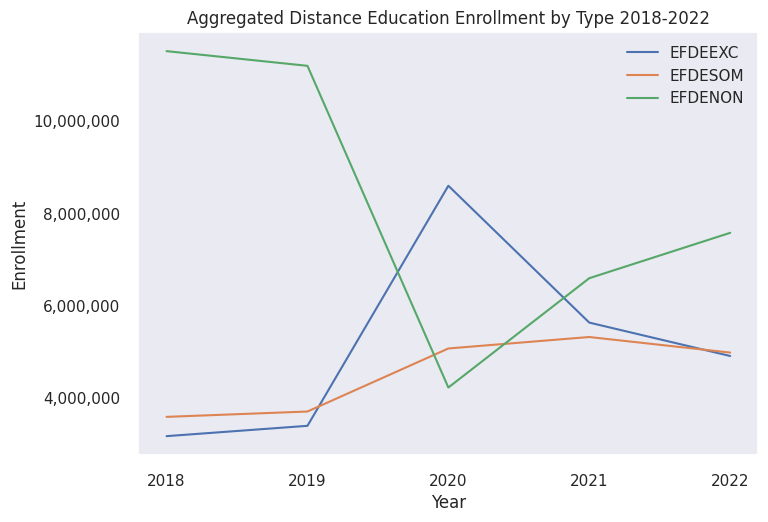

In [ ]:
#plot aggregated 2018-2022 distance education enrollment data by type
agg_data1822, fig = plot_aggregated_enrollment_data(filt_enroll_data_1822)

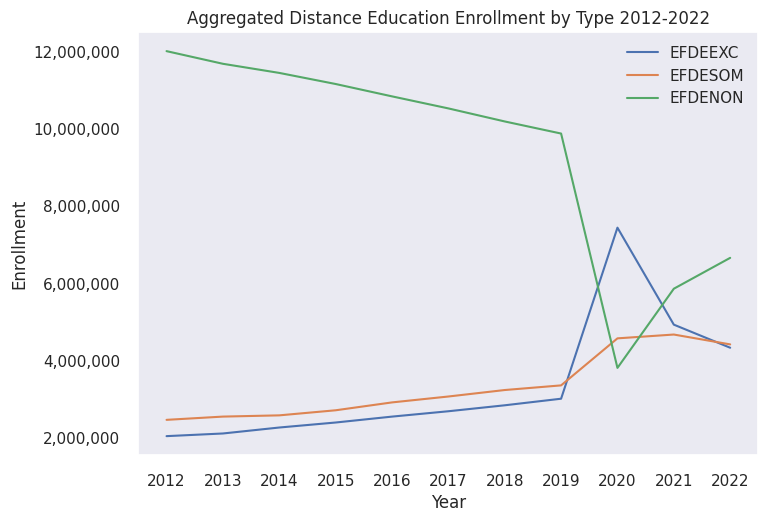

In [ ]:
agg_data1222, fig2 = plot_aggregated_enrollment_data(filt_enroll_data_1222)

In [ ]:
def extract_data(data):
    data= data[['YEAR', 'EFDEEXC']]
    return data


data1822 = extract_data(agg_data1822)
data1222 = extract_data(agg_data1222)


In [ ]:
data1822_no20=data1822[data1822['YEAR']!= 2020]
data1222_no20=data1222[data1222['YEAR']!= 2020]

# data1822_no20

In [ ]:
# data1822
# data1822_no20

,YEAR,EFDEEXC
0,2018,3159019
1,2019,3382992
3,2021,5623201
4,2022,4898232


#PyCaret Timeseries Forecasting- data (with 2020)

In [ ]:
data1822['YEAR'] = pd.to_datetime(data1822['YEAR'], format='%Y').dt.year
data1222['YEAR'] = pd.to_datetime(data1222['YEAR'], format='%Y').dt.year




,YEAR,EFDEEXC
0,2018,3159019
1,2019,3382992
2,2020,8593245
3,2021,5623201
4,2022,4898232


In [ ]:
def split_train_test(data):
    train = data[data['YEAR'] < 2022]
    test = data[data['YEAR'] >= 2022]
    return train, test


train, test= split_train_test(data1822)
train2, test2= split_train_test(data1222)


In [ ]:
# Global Figure Settings
fig_kwargs = {
    # "renderer": "colab",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [ ]:
from pycaret.regression import *

def pycaret_regression_setup(data, test_data, target, numeric_features=['YEAR'], fold=3, session_id=123):
    """
    Function to set up PyCaret regression experiment with time-series data.

    Parameters:
    - data (df): training data.
    - test_data (df): test data.
    - target (str): Name of target column.
    - numeric_features (list): list of other column names containing numeric features.
    - fold (int): number of folds for time-series cross-validation.
    - session_id (int): random seed for reproducibility.
    -experiment_name: name for logging

    Returns:
    - PyCaret regression experiment object.
    """
    setup_kwargs = {
        'data': data,
        'test_data': test_data,
        'target': target,
        'fold_strategy': 'timeseries',
        'data_split_shuffle': False,
        'fold_shuffle': False,
        'numeric_features': numeric_features,
        'fold': fold,
        'session_id': session_id,

    }

    exp = setup(**setup_kwargs,log_experiment=True)
    return exp


In [ ]:
s1822 =pycaret_regression_setup(train, test, target = 'EFDEEXC')

# s1822 = setup(data = train, test_data = test, target = 'EFDEEXC', fold_strategy = 'timeseries',data_split_shuffle= False,
#               fold_shuffle = False, numeric_features = ['YEAR'], fold = 3,  session_id = 123)

,Description,Value
0,Session id,123
1,Target,EFDEEXC
2,Target type,Regression
3,Original data shape,"(5, 2)"
4,Transformed data shape,"(5, 2)"
5,Transformed train set shape,"(4, 2)"
6,Transformed test set shape,"(1, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


In [ ]:
s1222 =pycaret_regression_setup(train2, test2, target = 'EFDEEXC')

# s1222 = setup(data = train2, test_data = test2, target = 'EFDEEXC', fold_strategy = 'timeseries',data_split_shuffle= False,
#               fold_shuffle = False, numeric_features = ['YEAR'], fold = 3,  session_id = 123)

,Description,Value
0,Session id,123
1,Target,EFDEEXC
2,Target type,Regression
3,Original data shape,"(11, 2)"
4,Transformed data shape,"(11, 2)"
5,Transformed train set shape,"(10, 2)"
6,Transformed test set shape,"(1, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


#Compare Models

In [ ]:
best1822=s1822.compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2041442.7222,9570204974663.3770,2041442.7222,nan,0.3810,0.2628,0.0300
dummy,Dummy Regressor,2041442.7222,9570204974711.5645,2041442.7222,nan,0.3810,0.2628,0.0233
lightgbm,Light Gradient Boosting Machine,2041442.7222,9570204974711.5645,2041442.7222,nan,0.3810,0.2628,0.5167
rf,Random Forest Regressor,2385900.0000,10204152465112.3398,2385900.0000,nan,0.4261,0.3251,0.2667
huber,Huber Regressor,2555972.9413,10727689471893.7109,2555972.9413,nan,0.5023,0.3566,0.0667
par,Passive Aggressive Regressor,2630156.9729,11075938522748.7910,2630156.9729,nan,0.5250,0.3697,0.0300
en,Elastic Net,2653794.1587,11194475150029.1270,2653794.1587,nan,0.4573,0.3740,0.0300
gbr,Gradient Boosting Regressor,2801392.9101,12005844259131.5645,2801392.9101,nan,0.4749,0.4002,0.0800
xgboost,Extreme Gradient Boosting,2801422.5833,12006017195266.3535,2801422.5833,nan,0.4749,0.4002,0.0567
ada,AdaBoost Regressor,2801423.3333,12006020530224.6660,2801423.3333,nan,0.4749,0.4002,0.0300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
best1222=s1222.compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1030177.2552,3564436185614.1665,1124964.3214,-1.5823,0.2388,0.1650,0.0367
lar,Least Angle Regression,1030177.2552,3564436185614.1665,1124964.3214,-1.5823,0.2388,0.1650,0.0400
omp,Orthogonal Matching Pursuit,1030177.2552,3564436185614.1665,1124964.3214,-1.5823,0.2388,0.1650,0.0267
lasso,Lasso Regression,1030178.8298,3564438130810.2017,1124965.8595,-1.5823,0.2388,0.1650,0.0433
llar,Lasso Least Angle Regression,1030178.8298,3564438130810.2017,1124965.8595,-1.5823,0.2388,0.1650,0.0267
ridge,Ridge Regression,1065424.9418,3600378264968.8843,1159726.6978,-2.4776,0.2517,0.1769,0.0433
en,Elastic Net,1111185.6169,3694485649923.2666,1203860.5392,-3.8385,0.2677,0.1905,0.0467
ada,AdaBoost Regressor,1210472.5000,3913964561467.8335,1298578.8874,-8.1833,0.3028,0.2188,0.0600
et,Extra Trees Regressor,1210472.5000,3913964561467.8335,1298578.8874,-8.1833,0.3028,0.2188,0.1333
dt,Decision Tree Regressor,1210472.5000,3913964561467.8335,1298578.8874,-8.1833,0.3028,0.2188,0.0300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

#Analyze Model

#Prediction

In [ ]:
#generate predictions on original dataset and plot orginal vs. predicted values

def plot_predictions(data, model, target_col='EFDEEXC', prediction_col='prediction_label'):

    # Generate predictions on the original dataset
    predictions = predict_model(model, data=data)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(predictions['YEAR'], predictions[target_col], marker='o', label='EFDEEXC')
    plt.plot(predictions['YEAR'], predictions[prediction_col], marker='o', label='Prediction')
    plt.xlabel('YEAR')
    plt.ylabel('Value')
    plt.title('EFDEEXC vs Prediction 2018-2022')

    # Remove scientific notation, add commas on y-axis
    formatter = StrMethodFormatter('{x:,.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Set x-axis to integer years
    plt.xticks(predictions['YEAR'])

    plt.legend()
    plt.grid(False)
    plt.show()



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1593163.4500,3848960878247.8296,1961876.8764,-0.0009,0.3725,0.3419


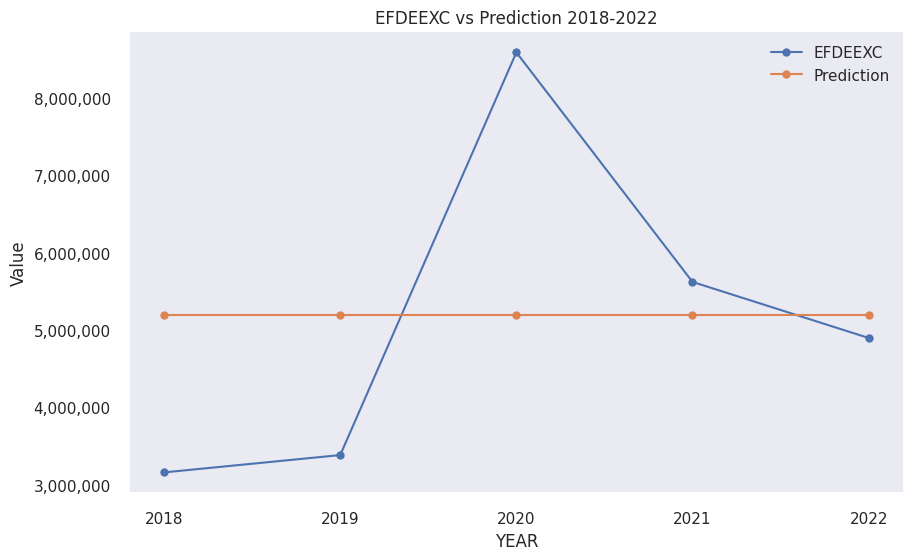

In [ ]:

predictions1822 = plot_predictions(data=data1822, model=best1822)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,807563.1537,1182764690967.5908,1087549.8568,0.5166,0.2657,0.2291


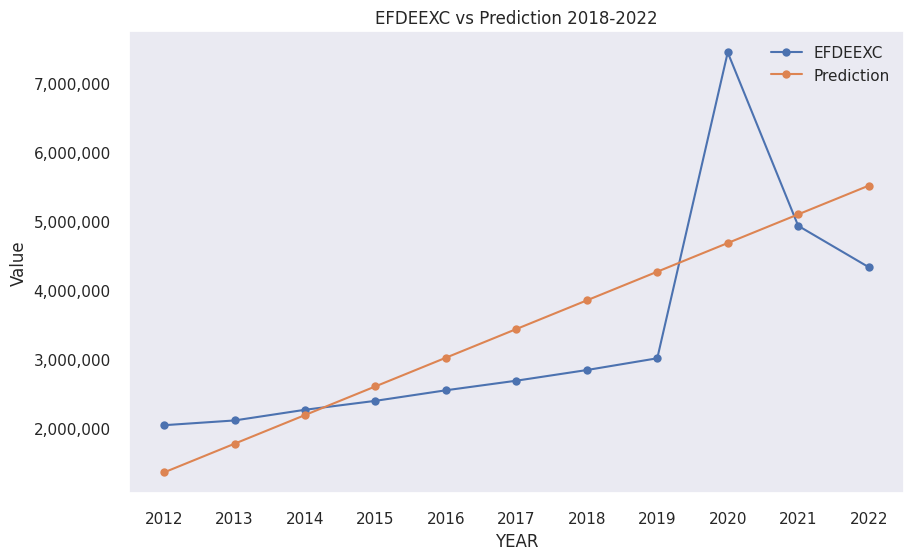

In [ ]:

predictions1222 = plot_predictions(data=data1222, model=best1222)


In [ ]:
pred_holdout1822 = predict_model(best1822)
pd.options.display.float_format = '{:.0f}'.format
pred_holdout1822

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,854457.2500,730097192083.1823,854457.2500,nan,0.1799,0.1971


,YEAR,EFDEEXC,prediction_label
10,2022,4335157,5189614


In [ ]:
pred_holdout1222 = predict_model(best1222)
pd.options.display.float_format = '{:.0f}'.format
pred_holdout1222

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1177652.6667,1386865803307.0176,1177652.6667,nan,0.2403,0.2717


,YEAR,EFDEEXC,prediction_label
10,2022,4335157,5512810


#Forecasting

In [ ]:
#finalize models
final_best1822 = finalize_model(best1822)
final_best1222 = finalize_model(best1222)

In [ ]:
#create future scoring dataset- 5 years
future_dates = pd.date_range(start = '2023', end = '2028', freq = 'A-OCT')

future_df = pd.DataFrame()
future_df['YEAR']= [i.year for i in future_dates]
# future_df1822

In [ ]:
def predict_future(model, future_data, target_col='prediction_label', new_target_col='EFDEEXC_Forecast'):

    # Generate predictions on future data
    predictions = predict_model(model, data=future_data)

    # Rename prediction column
    predictions = predictions.rename(columns={target_col: new_target_col})

    # Format floating-point numbers
    pd.options.display.float_format = '{:.0f}'.format

    return predictions



,YEAR,EFDEEXC_Forecast
0,2023,5499258
1,2024,5860413
2,2025,6221569
3,2026,6582724
4,2027,6943880


In [ ]:
preds1822 = predict_future(model= final_best1822, future_data =future_df)
preds1822

,YEAR,EFDEEXC_Forecast
0,2023,3332324
1,2024,3332324
2,2025,3332324
3,2026,3332324
4,2027,3332324


In [ ]:

preds1222 = predict_future(model= final_best1222, future_data =future_df)
preds1222

,YEAR,EFDEEXC_Forecast
0,2023,5499258
1,2024,5860413
2,2025,6221569
3,2026,6582724
4,2027,6943880


In [ ]:
concat_df1822 = pd.concat([data1822,preds1822], axis=0)
concat_df1222 = pd.concat([data1222,preds1222], axis=0)
concat_df1822.reset_index(drop=True, inplace =True)
concat_df1222.reset_index(drop=True, inplace =True)

,YEAR,EFDEEXC,EFDEEXC_Forecast
0,2012,2048498,NaN
1,2013,2117172,NaN
2,2014,2271525,NaN
3,2015,2400953,NaN
4,2016,2553603,NaN
5,2017,2692232,NaN
6,2018,2846372,NaN
7,2019,3016528,NaN
8,2020,7440943,NaN
9,2021,4932583,NaN


In [ ]:
#plot actual and forecasted results
def plot_enrollment_forecast(combined_data, forecast_df, year_range):
    plt.figure(figsize=(10, 6))

    # Plot actual enrollment
    plt.plot(combined_data['YEAR'], combined_data['EFDEEXC'], color='blue', label='Enrollment')

    # Highlight forecasted values
    plt.plot(forecast_df['YEAR'], forecast_df['EFDEEXC_Forecast'], linestyle='--', color='red', label='Forecasted Enrollment')

    # Get the index for the year 2022
    index_2022 = combined_data[combined_data['YEAR'] == 2022].index[0]

    # Plot a line connecting the actual and forecasted values at 2022
    plt.plot([combined_data['YEAR'].iloc[index_2022], forecast_df['YEAR'].iloc[0]],
             [combined_data['EFDEEXC'].iloc[index_2022], forecast_df['EFDEEXC_Forecast'].iloc[0]],
             linestyle='--', color='red')

    plt.xlabel('Year')
    plt.ylabel('Enrollment')
    plt.title('Actual vs. 5 year Forecasted Enrollment ({} data)'.format(year_range))

    # # Set integer year ticks on the x-axis
    # plt.xticks(range(combined_data['YEAR'].min(), combined_data['YEAR'].max() + 1))


    # Remove scientific notation, add commas on y-axis
    formatter = StrMethodFormatter('{x:,.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)


    plt.legend()
    plt.grid(False)
    plt.show()

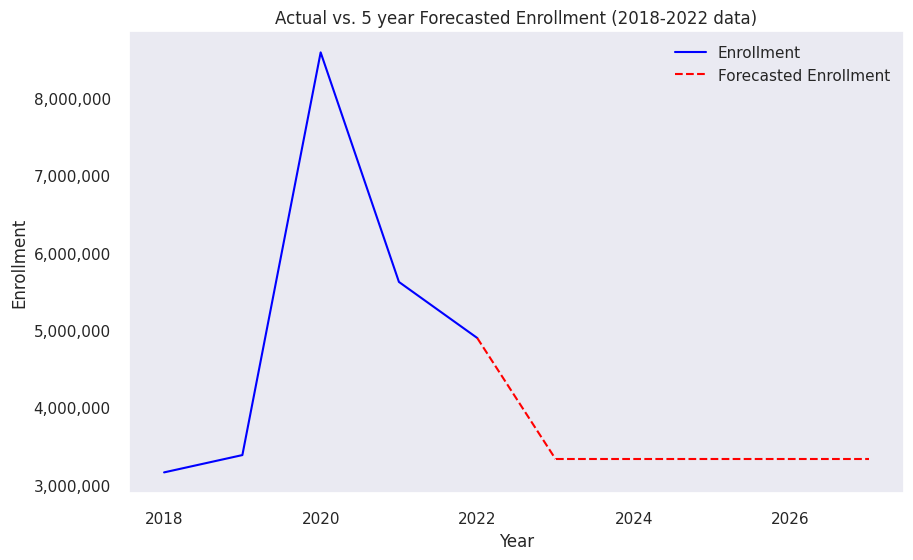

In [ ]:
plot_enrollment_forecast(concat_df1822, preds1822, '2018-2022' )

In [ ]:
plot_enrollment_forecast(concat_df1222, preds1222, '2012-2022' )

#With 2020 data removed

In [ ]:
# data1822_no20=data1822[data1822['YEAR']!= 2020]
# data1222_no20=data1222[data1222['YEAR']!= 2020]
# data1822_no20

In [ ]:
train3, test3= split_train_test(data1822_no20)
train4, test4= split_train_test(data1222_no20)

In [ ]:
s1822no20 =pycaret_regression_setup(train3, test3, target = 'EFDEEXC')

,Description,Value
0,Session id,123
1,Target,EFDEEXC
2,Target type,Regression
3,Original data shape,"(4, 2)"
4,Transformed data shape,"(4, 2)"
5,Transformed train set shape,"(3, 2)"
6,Transformed test set shape,"(1, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


In [ ]:
s1222no20 =pycaret_regression_setup(train4, test4, target = 'EFDEEXC')

,Description,Value
0,Session id,123
1,Target,EFDEEXC
2,Target type,Regression
3,Original data shape,"(10, 2)"
4,Transformed data shape,"(10, 2)"
5,Transformed train set shape,"(9, 2)"
6,Transformed test set shape,"(1, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


In [ ]:
#compare models
best1822_no20=s1822no20.compare_models(sort='MAE')
best1822_no20

Processing:   0%|          | 0/81 [00:00<?, ?it/s]

[]

In [ ]:
best1222_no20=s1222no20.compare_models(sort = 'MAE')
best1222_no20

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,321189.5825,480395374873.5376,431711.6128,0.2050,0.1116,0.0716,2.0567
lar,Least Angle Regression,321189.5825,480395374873.5376,431711.6128,0.2050,0.1116,0.0716,0.0400
omp,Orthogonal Matching Pursuit,321189.5825,480395374873.5376,431711.6128,0.2050,0.1116,0.0716,0.0500
lasso,Lasso Regression,321191.8325,480396427720.9531,431713.8093,0.2049,0.1116,0.0716,0.0300
llar,Lasso Least Angle Regression,321191.8325,480396427720.9531,431713.8093,0.2049,0.1116,0.0716,0.0500
ridge,Ridge Regression,373742.3700,505061569846.3321,483701.0465,-1.2128,0.1319,0.0910,0.0333
en,Elastic Net,416512.7739,549547998293.1974,524609.0642,-2.3563,0.1469,0.1049,0.0433
dt,Decision Tree Regressor,516545.1667,763746782187.8334,642860.0624,-5.4956,0.1893,0.1330,0.0367
et,Extra Trees Regressor,516545.1667,763746782187.8334,642860.0624,-5.4956,0.1893,0.1330,0.1667
ada,AdaBoost Regressor,516545.1667,763746782187.8334,642860.0624,-5.4956,0.1893,0.1330,0.0733


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

LinearRegression(n_jobs=-1)

In [ ]:
# preds1822_no20 = plot_predictions(data=data1822_no20, model=best1822_no20)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,297230.6081,150761418201.9873,388280.0770,0.8194,0.1185,0.0985


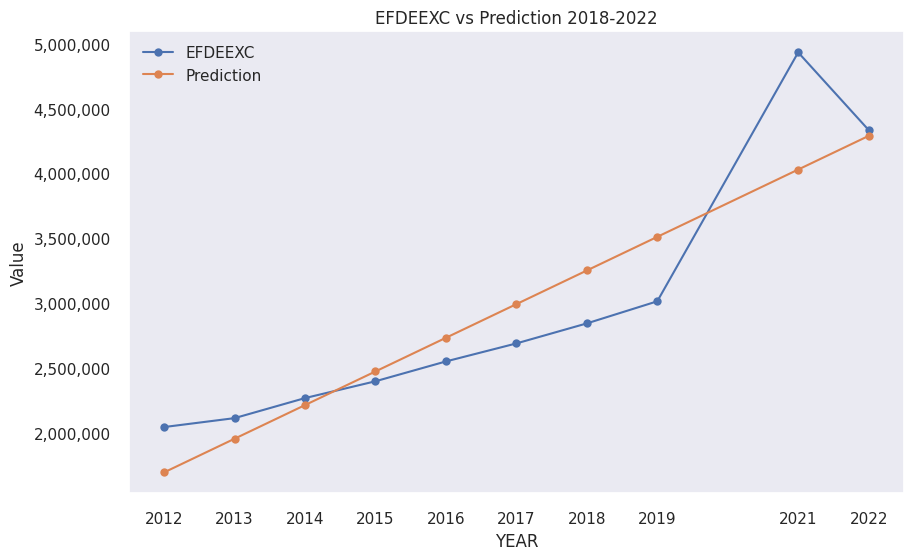

In [ ]:
preds1222_no20 = plot_predictions(data=data1222_no20, model=best1222_no20)

In [ ]:
# pred_holdout1822_no20 = predict_model(best1822_no20)
# pd.options.display.float_format = '{:.0f}'.format
# pred_holdout1822_no20

In [ ]:
pred_holdout1222_no20 = predict_model(best1222_no20)
pd.options.display.float_format = '{:.0f}'.format
pred_holdout1222_no20

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,45433.6935,2064220509.4536,45433.6935,nan,0.0105,0.0105


,YEAR,EFDEEXC,prediction_label
10,2022,4335157,4289723


In [ ]:
#finalize models
# finalbest_1822no20 = finalize_model(best1822_no20)
finalbest_1222no20 = finalize_model(best1222_no20)

In [ ]:
#create future scoring dataset- 5 years
future_dates = pd.date_range(start = '2023', end = '2028', freq = 'A-OCT')

future_df = pd.DataFrame()
future_df['YEAR']= [i.year for i in future_dates]


In [ ]:
# preds1822_no20 = predict_future(model= finalbest_1822no20, future_data =future_df)
# preds1822_no20

In [ ]:
preds1222_no20 = predict_future(model= finalbest_1222no20, future_data =future_df)
preds1222_no20

,YEAR,EFDEEXC_Forecast
0,2023,4568442
1,2024,4829867
2,2025,5091292
3,2026,5352717
4,2027,5614143


In [ ]:
# concat_df1822no20 = pd.concat([data1822_no20,preds1822_no20], axis=0)

concat_df1222no20 = pd.concat([data1222_no20,preds1222_no20], axis=0)
concat_df1222no20.reset_index(drop=True, inplace =True)

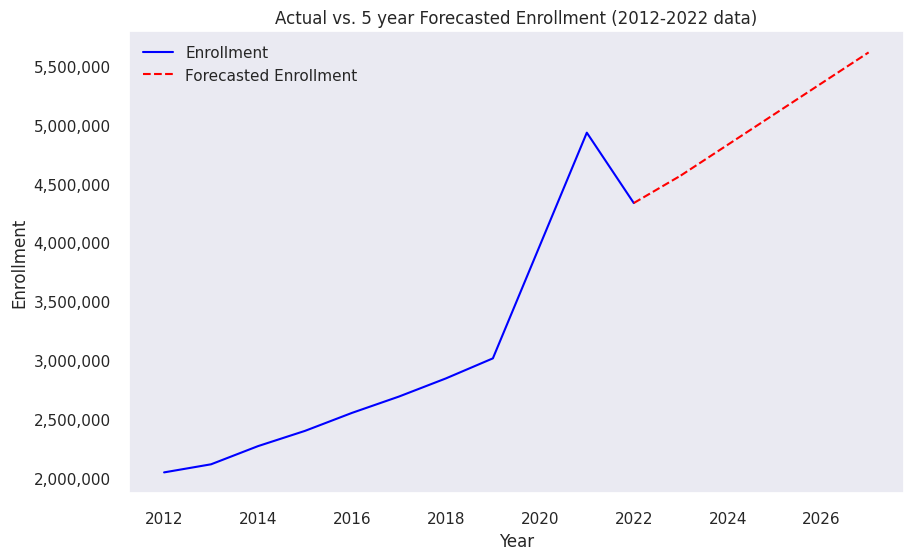

In [ ]:
plot_enrollment_forecast(concat_df1222no20, preds1222_no20, '2012-2022' )